In [1]:
import h5py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# models
MODEL_PATH = '/home/ankbzpx/Documents/'

discrete_encoder_path = MODEL_PATH + 'discrete continuous shape/discrete_encoder_model_256.pth'
discrete_decoder_path = MODEL_PATH + 'discrete continuous shape/discrete_decoder_model_256.pth'
unet_path = MODEL_PATH + 'discrete continuous shape/unet.pth'
continuous_model_path = MODEL_PATH + 'discrete continuous shape/continuous_model.pth'

hidden_dim_discrete = 128

# data preparation
data_file = '/home/ankbzpx/datasets/ShapeNet/ShapeNetRenderingh5_v1/03001627/data_test.h5'
sample_size = 2048
batch_size = 4
split_ratio = 0.9
depth_size = 256
num_of_workers = 12

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from PIL import Image

In [5]:
# reproducible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
    
#device = torch.device("cpu")
torch.manual_seed(0)
np.random.seed(0)

In [6]:
device

device(type='cuda')

In [7]:
class ChairDepthDataset(Dataset):
    
    def __init__(self, h5_file, transform=None):
        
        self.hf = h5py.File(h5_file, 'r')
        self.keys = list(self.hf.keys())
        
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        
        group = self.hf[self.keys[idx]]
        
        model_id = str(group['model_id'])
        depth_img = Image.fromarray(np.array(group['depth_img']))
        azimuth = float(group['azimuth'][()])
        elevation = float(group['elevation'][()])
        distance = float(group['distance'][()])
        target_vox = torch.tensor(group['target_vox'], dtype=torch.float)
        
        if self.transform:
            depth_img = self.transform(depth_img)
        
        depth_img = nn.functional.interpolate(depth_img.unsqueeze(0), size=256, mode='nearest').squeeze(0)
        
        sample = {'model_id': model_id,
                  'depth_img': depth_img,
                  'azimuth': azimuth,
                  'elevation': elevation,
                  'distance': distance,
                  'target_vox': target_vox, 
                 }

        return sample

In [8]:
test_depth_dataset = ChairDepthDataset(data_file,
                         transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, ), (0.5, ))
                                ]))

test_size = len(test_depth_dataset)

print('Test size: ', test_size)

test_depth_dataloader = DataLoader(test_depth_dataset, batch_size=batch_size, shuffle=False, num_workers=num_of_workers)

Test size:  31464


In [9]:
class UNET_FULL(nn.Module):
    def __init__(self, channel_size = 16):
        super(UNET_FULL, self).__init__()
        
        self.channel = channel_size
        
        self.down1 = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*channel_size),
            nn.ReLU(),
        )
        
        self.down2 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
        )
        
        self.down3 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
        )
        
        self.down4 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up1 = nn.Sequential(
            nn.Conv3d(in_channels = (16 + 8)*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up2 = nn.Sequential(
            nn.Conv3d(in_channels = (8 + 4)*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up3 = nn.Sequential(
            nn.Conv3d(in_channels = (4 + 2)*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 3, kernel_size = 3, stride=1, padding=1),
        )
        
    def forward(self, x):
        
        context1 = self.down1(x)
        context2 = self.down2(context1)
        context3 = self.down3(context2)
        out = self.down4(context3)
        
        out = self.up1(torch.cat((context3, out), 1))
        out = self.up2(torch.cat((context2, out), 1))
        out = self.up3(torch.cat((context1, out), 1))
        
        return out

In [10]:
class UNET(nn.Module):
    def __init__(self, unet_path):
        super(UNET, self).__init__()
        
        unet_full = UNET_FULL()
        unet_full.load_state_dict(torch.load(unet_path))
        
        priors = list(unet_full.children())
        
        self.down1 = priors[0]
        self.down2 = priors[1]
        self.down3 = priors[2]
        self.down4 = priors[3]
        self.up1 = priors[4]
        self.up2 = priors[5]
        
        module_list = []
        
        last = list(priors[6].children())
    
        for p in range(len(last)-1):
            module_list.append(last[p])
        
        self.up3 = nn.Sequential(*module_list)
        
    def forward(self, x):
        
        context1 = self.down1(x)
        context2 = self.down2(context1)
        context3 = self.down3(context2)
        out = self.down4(context3)
        
        out = self.up1(torch.cat((context3, out), 1))
        out = self.up2(torch.cat((context2, out), 1))
        out = self.up3(torch.cat((context1, out), 1))
        
        return out

In [11]:
class Continuous(nn.Module):
    def __init__(self, pt_dim = 3, con_dim = 32, latent_dim = 256):
        super(Continuous, self).__init__()
        
        self.de_pt = nn.Sequential(
            nn.Linear(pt_dim + con_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
        )
        
        self.de_1 = nn.Sequential(
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
        )
        
        self.de_2 = nn.Sequential(
            nn.Linear(4*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 2*latent_dim),
            nn.BatchNorm1d(2*latent_dim),
            nn.ReLU(),
            nn.Linear(2*latent_dim, 1),
            nn.Tanh(),
        )
        
        
    def forward(self, pt, con, z):
        
        cat = torch.cat((self.de_pt(torch.cat((pt, con), 1)), z), 1)
        out = self.de_1(cat)
        out = self.de_2(torch.cat((out, cat), 1))
        
        return out

In [12]:
from models import Discrete_encoder, Discrete_decoder

discrete_encoder = Discrete_encoder(256).to(device)
discrete_encoder.load_state_dict(torch.load(discrete_encoder_path))
e = discrete_encoder.eval()

discrete_decoder = Discrete_decoder(256).to(device)
discrete_decoder.load_state_dict(torch.load(discrete_decoder_path))
e = discrete_decoder.eval()

unet = UNET(unet_path).to(device)
#unet.load_state_dict(torch.load(unet_path))
e = unet.eval()

continuous = Continuous().to(device)
continuous.load_state_dict(torch.load(continuous_model_path))
e = continuous.eval()

In [13]:
import skimage.measure as sk

# advanced indexing 2x2x2 context from voxel
def getContext(sample_pt_query, vox):
    
    # sample_pt bxcxdimxdimxdim
    # vox bxmx3
    
    channel_size = vox.shape[1]
    batch_size, sample_size, _ = sample_pt_query.shape
    meshgrid_base = torch.Tensor(np.meshgrid(np.arange(0, batch_size), np.arange(0, channel_size), np.arange(0, 2), np.arange(0, 2), np.arange(0, 2))).int()
    context = torch.empty((batch_size, sample_size, channel_size, 2, 2, 2))

    for j in range(context.shape[1]):
        context[:, j, :, :, :, :] = vox[
                    meshgrid_base[0].long(),
                    meshgrid_base[1].long(),
                    (meshgrid_base[2] + sample_pt_query[:, j, 0].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[3] + sample_pt_query[:, j, 1].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[4] + sample_pt_query[:, j, 2].reshape(1, -1, 1, 1, 1)).long()
                ].transpose(0, 1)
    
    # b x c x m x 2 x 2 x 2
    return context.transpose(1, 2)


def trilinearInterpolation(context, dx, dy, dz):
    
    v0 = context[:, :, :, 0, 0, 0]*(1-dx)*(1-dy)*(1-dz)
    v1 = context[:, :, :, 1, 0, 0]*dx*(1-dy)*(1-dz)
    v2 = context[:, :, :, 0, 1, 0]*(1-dx)*dy*(1-dz)
    v3 = context[:, :, :, 1, 1, 0]*dx*dy*(1-dz)
    v4 = context[:, :, :, 0, 0, 1]*(1-dx)*(1-dy)*dz
    v5 = context[:, :, :, 1, 0, 1]*dx*(1-dy)*dz
    v6 = context[:, :, :, 0, 1, 1]*(1-dx)*dy*dz
    v7 = context[:, :, :, 1, 1, 1]*dx*dy*dz
    
    # b x c x m 1
    return v0 + v1 + v2 + v3 + v4 + v5 + v6 + v7
    

# generate mesh from continuous model
def generate_mesh(continuous, unet, out_vox, z, device, con_dim = 32, latent_dim = 256, vox_res = 32, grid_res = 64, batch_size = 32, isosurface = 0.0):
    
    vox = np.zeros((grid_res, grid_res, grid_res))
    idx = np.array(np.where(vox == 0))
    
    # normalize
    sample_pt = (torch.t(torch.tensor(idx/grid_res, dtype=torch.float)) - 0.5)
    sample_pt = sample_pt.reshape(-1, sample_size, 3)
    
    sample_pt_normalized = sample_pt + torch.tensor([0.5, 0.5, 0.5])
    # (0, 63)
    sample_pt_scale = torch.clamp(sample_pt_normalized* (vox_res-1), 0, (vox_res-1)-1e-5)
    # (0, 62]
    sample_pt_query = torch.clamp((sample_pt_scale).int(), 0, (vox_res-2))
    sample_pt_distance = sample_pt_scale - sample_pt_query
    
    
    vox_feature = unet(out_vox).repeat(batch_size, 1, 1, 1, 1).detach().cpu()
    
    print("Data generation")
    
    pre_sdf_list = []
    
    for i in range(int(sample_pt.shape[0]/batch_size)):
        
        start = i*batch_size
        end = (i + 1)*batch_size
        
        context = getContext(sample_pt_query[start:end, :, :], vox_feature)
        
        dx = sample_pt_distance[start:end, :, 0].unsqueeze(1)
        dy = sample_pt_distance[start:end, :, 1].unsqueeze(1)
        dz = sample_pt_distance[start:end, :, 2].unsqueeze(1)
        
        # local feature
        con = trilinearInterpolation(context, dx, dy, dz).to(device).transpose(-1, -2).reshape(-1, con_dim)
        # global feature
        latent = z.squeeze(-1).squeeze(-1).repeat(batch_size, 1, sample_size).transpose(-1, -2).reshape(-1, latent_dim)       
        # point
        sample_pt_batch = sample_pt[start:end, :, :].transpose(-1, -2).to(device).transpose(-1, -2).reshape(-1, 3)
        
        
        # avoid occupying gpu memory
        pred_sdf_batch = continuous(sample_pt_batch, 
                                    con,
                                    latent,
                                   ).squeeze(1).detach().cpu()
        
        pre_sdf_list.append(pred_sdf_batch)
        
    pred_sdf = torch.cat(pre_sdf_list).reshape(-1,)
    
    vox[tuple([idx[0], idx[1], idx[2]])] = pred_sdf[:].numpy()
    
    print("Success generation")
    
    verts, faces, _, _ =  sk.marching_cubes_lewiner(vox, level=isosurface)
    
    print("Marching cube")
    
    mesh = pymesh.form_mesh(verts, faces)
    dis_meshes = pymesh.separate_mesh(mesh, connectivity_type='auto')
    
    max_vertices = 0
    current_i = 0
    for i in range(len(dis_meshes)):

        if dis_meshes[i].vertices.shape[0] > max_vertices:
            max_vertices = dis_meshes[i].vertices.shape[0]
            current_i = i
    
    mesh = dis_meshes[current_i]
    
    return mesh

In [14]:
# 24

<IPython.core.display.Javascript object>


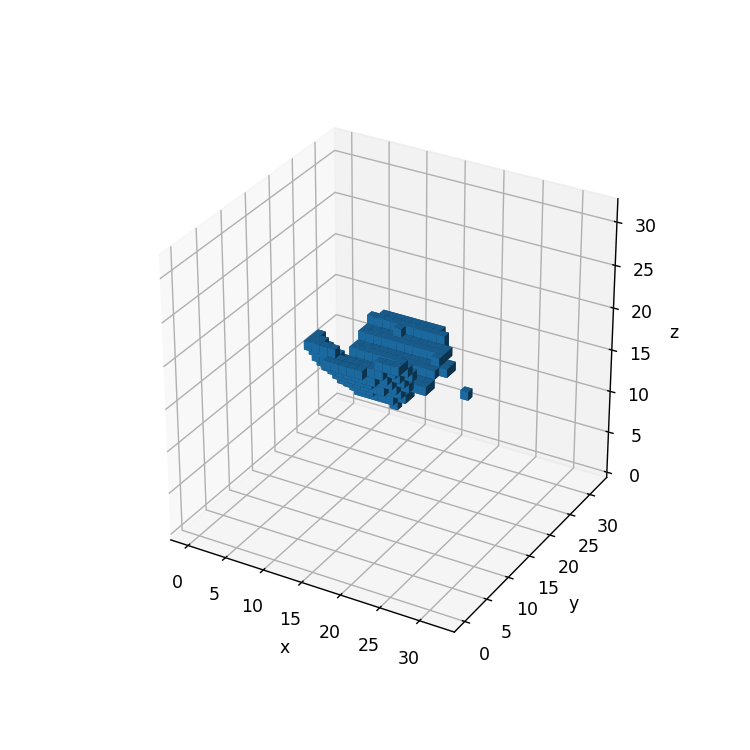

<IPython.core.display.Javascript object>


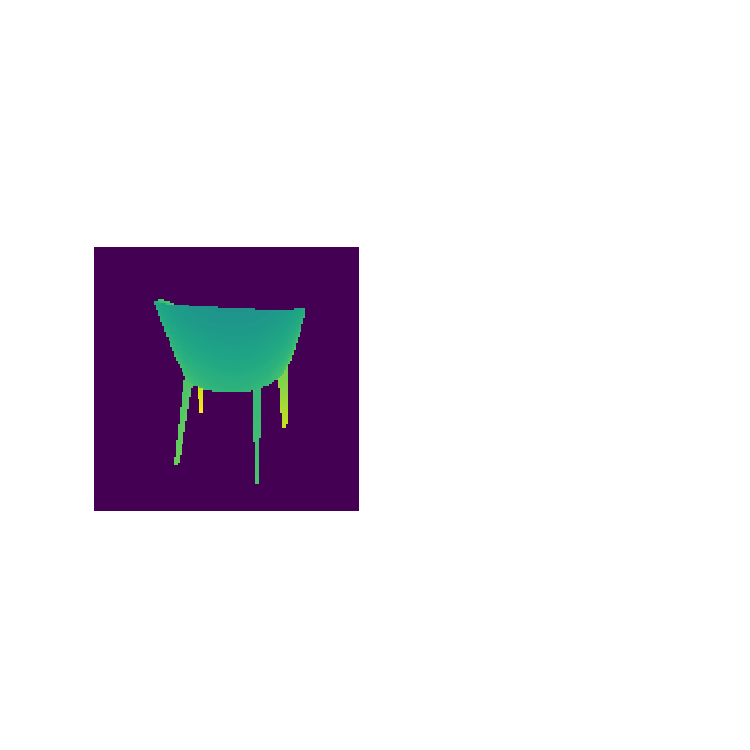

In [78]:
%matplotlib notebook

import dataIO
import matplotlib.pyplot as plt

data = test_depth_dataset[31*24]

test_depth_img = data['depth_img'].to(device)

#dataIO.plotFromVoxels(data['target_vox'].cpu().numpy())

z = discrete_encoder(test_depth_img.unsqueeze(0))

out_vox = torch.sigmoid(discrete_decoder(z))

#print(discrete(test_depth_img.unsqueeze(0)))

dataIO.plotFromVoxels(out_vox.detach().cpu().numpy()[0, 0, :, :, :] > 0.5)

plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(data['depth_img'][0,:,:])
plt.show()

In [79]:
import time
import models
import dataIO
import pymesh

mesh = generate_mesh(continuous, unet, out_vox, z, device, grid_res = 64, isosurface = 0)
#dataIO.plotFromVF(mesh.vertices, mesh.faces)

Data generation
Success generation
Marching cube


In [80]:
import pyrender
import trimesh

model = trimesh.Trimesh(mesh.vertices,mesh.faces)
mesh_py = pyrender.Mesh.from_trimesh(model)
scene = pyrender.Scene()
scene.add(mesh_py)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

In [ ]:
add_mesh